In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import random
import pandas as pd
import seaborn as sns

sns.set_context("talk")
%matplotlib inline

/Users/stolentino/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/stolentino/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/stolentino/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [126]:
!scp pi@192.168.1.189:hydrofarm/data/sensor_data.csv ../data/

sensor_data.csv                               100%   13KB   6.3KB/s   00:02    


In [107]:
sensor = pd.read_csv('../data/sensor_data.csv', names=['ts', 'temperature', 'light', 'moisture'])
sensor['ts'] = pd.to_datetime(sensor.ts)
sensor.set_index('ts', inplace=True)
sensor.tail()

,temperature,light,moisture
ts,,,
2018-12-04 13:55:01,24.823596,52,43
2018-12-04 14:00:01,25.176613,49,43
2018-12-04 14:05:01,24.823596,50,43
2018-12-04 14:10:02,24.823596,49,43
2018-12-04 14:15:01,24.823596,43,42


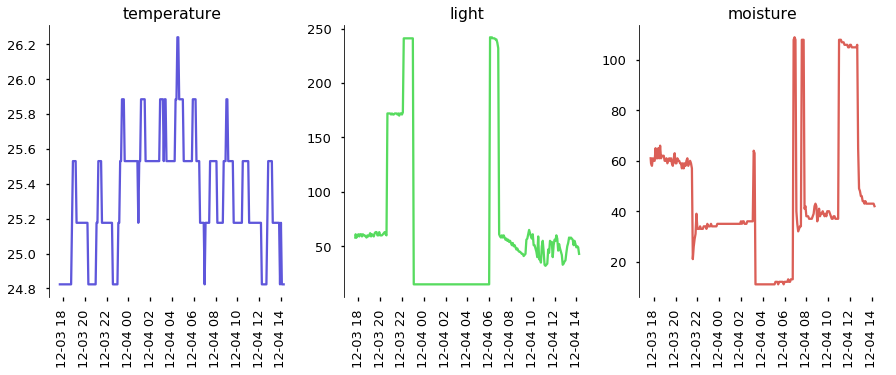

In [70]:
# finest granularity
cp = sns.color_palette('hls', 3)
plt.figure(figsize=(15,5))
for m,measure in enumerate(['temperature', 'light', 'moisture']):
    plt.subplot(1,3,m+1)
    plt.plot(sensor[measure], '-', color=cp.pop())
    plt.title(measure)
    plt.xticks(rotation=90)
sns.despine(bottom=True)

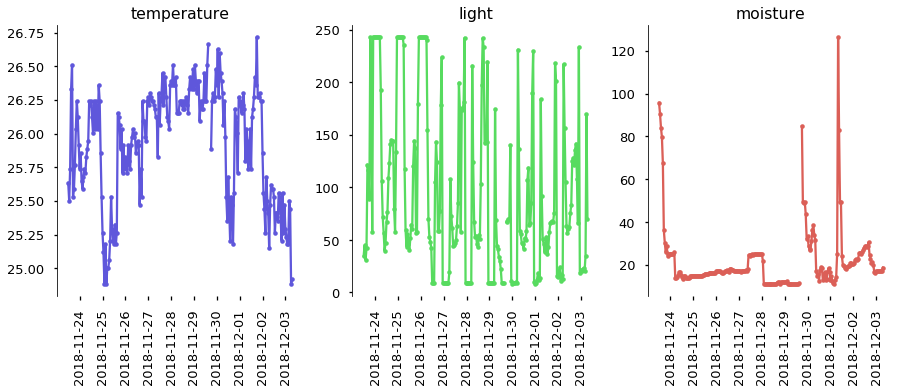

In [64]:
# agg to an hour
cp = sns.color_palette('hls', 3)
plt.figure(figsize=(15,5))
for m,measure in enumerate(['temperature', 'light', 'moisture']):
    plt.subplot(1,3,m+1)
    plt.plot(sensor[measure].resample('H').mean(), '.-', color=cp.pop())
    plt.title(measure)
    plt.xticks(rotation=90)
#plt.ylim(0,50)
sns.despine(bottom=True)

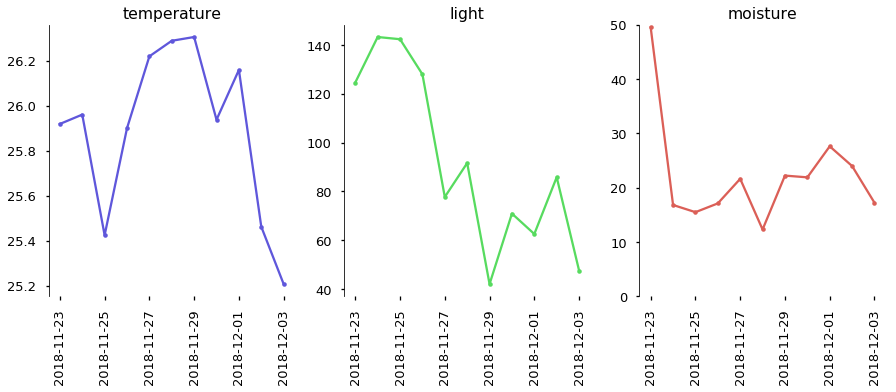

In [61]:
# agg to a day
cp = sns.color_palette('hls', 3)
plt.figure(figsize=(15,5))
for m,measure in enumerate(['temperature', 'light', 'moisture']):
    plt.subplot(1,3,m+1)
    plt.plot(sensor[measure].resample('D').mean(), '.-', color=cp.pop())
    plt.title(measure)
    plt.xticks(rotation=90)
plt.ylim(0,50)
sns.despine(bottom=True)

Conclusions: the ambient temperature is pretty stable, varying only within a few degrees. It seems higher than it should be though....

The light follows a predictable pattern: the reading is high at night time (high valued reading) and gradually lowers during the day. It begins to darken again as the sun sets by we'll often turn a light on in the room briefly for dinner. Note that I changed the lighting schedule such that lights turn on from midnight to 6am on 11/26 (when the sprouts started). 

Moisture, after being initially very high (dry), has settled around 15. This seems to imply that after a couple waterings the vermiculite has been saturated. 

# what are the daily patterns?

In [124]:
sensor = pd.read_csv('../archive/sensor_data_2018_12_03.csv', names=['ts', 'temperature', 'light', 'moisture'])
sensor['ts'] = pd.to_datetime(sensor.ts)
sensor.tail()

,ts,temperature,light,moisture
2796,2018-12-03 07:33:00,24.823596,69,19
2797,2018-12-03 07:38:00,24.823596,67,19
2798,2018-12-03 07:43:00,24.823596,68,19
2799,2018-12-03 07:48:00,25.176613,71,19
2800,2018-12-03 07:53:00,25.530488,69,19


In [125]:
sensor.to_csv('sensor_backup.csv', index=False)

/Users/stolentino/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


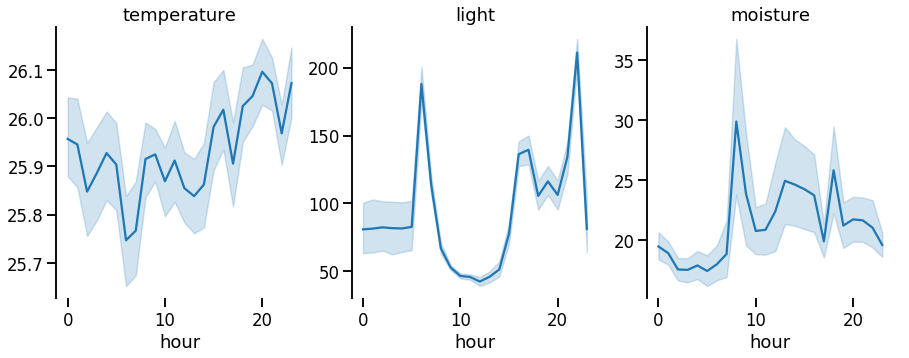

In [28]:
# time series distribution
plt.figure(figsize=(15,5))
for s,sense in enumerate(['temperature', 'light', 'moisture']):
    plt.subplot(1,3,s+1)
    sns.lineplot(x='hour', y=sense, data=sensor)
    plt.title(sense)
    sns.despine(bottom=True)
    plt.ylabel('')

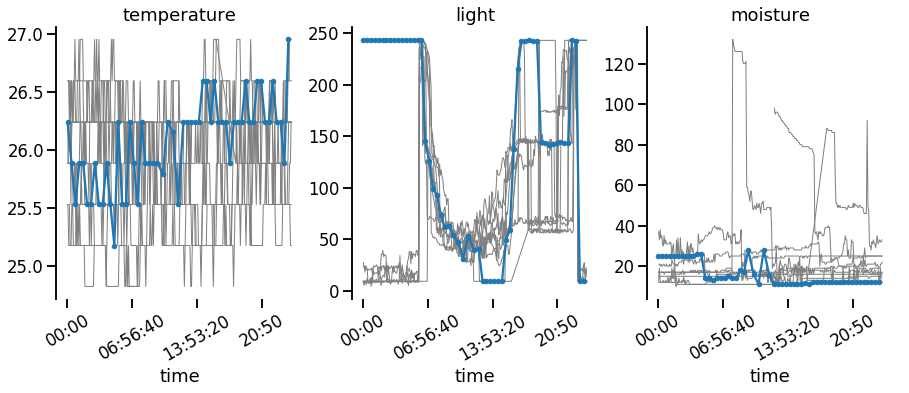

In [89]:
# I want to see the traces
sensor['time'] = sensor.ts.dt.time
means = sensor.groupby('time').agg(np.mean)
plt.figure(figsize=(15,5))
for s,sense in enumerate(['temperature', 'light', 'moisture']):
    plt.subplot(1,3,s+1)

    for date in sensor.ts.dt.date.unique():
        data = sensor[sensor.ts.dt.date==date]
        plt.plot(data.ts.dt.time, data[sense], '-', color='gray', lw=1)
    sns.despine(bottom=True)
    plt.plot(means[sense][::20], '.-')  # ticks every twenty minute
    plt.xticks(rotation=30)
    plt.title(sense)

# sending images to the server


In [13]:
import requests

fname = '../../plants/bottom left - 2018-12-17 13:00:02.jpg'  # arbitrarily choosen for testing
r = requests.post('http://192.168.1.190:5000/record/', files={'file':open(fname, 'rb')})
r.status_code

200

In [3]:
open(fname, 'rb')

<_io.BufferedReader name='../../plants/bottom left - 2018-12-17 13:00:02.jpg'>

In [8]:
r = requests.post('http://192.168.1.190:5000/record/')

Making timelapse gifs
======

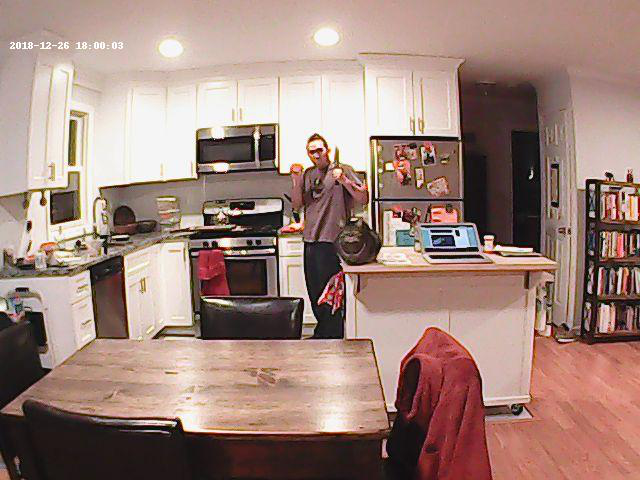

In [71]:
from PIL import Image, ImageDraw
Image.open(open('./../../plants/q5_2018-12-26_18:00:03.jpg', 'rb'))

In [226]:
import sys
import datetime
import imageio
import os

VALID_EXTENSIONS = ('png', 'jpg')
path = '/Users/stolentino/Desktop/hydrofarm/data/plants/'

def create_gif(filenames, output_name):
    images = []
    for filename in sorted(filenames):
        images.append(imageio.imread('%s%s'%(path, filename)))
    output_file = '../data/%s.gif'%output_name
    imageio.mimsave(output_file, images, duration=0.5)
    return images

In [122]:
# make a gif of one of the quadrants
filenames = [f for f in os.listdir(path) if 'q5' in f]
images = create_gif(filenames, 'q5')

In [227]:
# do it for every quadrant
for q in range(1,6):
    quad = 'q'+str(q)
    filenames = [f for f in os.listdir(path) if quad in f]
    print(quad, len(filenames))
    create_gif(filenames, quad)

q1 28
q2 28
q3 28
q4 28
q5 28


In [224]:
# save the 5 most recent to a html page for easy viewing
width = 250
height = width*(3/4)
f = open('../recent.html', 'w')

all_files = os.listdir(path)
quad_recent = [sorted([file for file in all_files if 'q'+str(quad) in file]) for quad in range(1,6)]
for quad in quad_recent:
    for i in range(-1, -6, -1):
        f.write('<IMG SRC="%s%s" height="%s" width="%s">\n'%(path, quad[i], height, width))
    f.write('\n')
f.close()
1+2

3

In [236]:
# also the time lapses for easy refreshing
width = 650
height = width*(3/4)
f = open('../timelapse.html', 'w')

gif_path = '/Users/stolentino/Desktop/hydrofarm/data/'
gifs = [f for f in os.listdir(gif_path) if f.endswith('gif')]
for gif in sorted(gifs):
    f.write('<IMG SRC="%s%s" height="%s" width="%s">\n'%(gif_path, gif, height, width))
f.close()
1+2

3

In [243]:
# copy the most recent 
width = 250
height = width*(3/4)

path = '/Users/stolentino/Desktop/plants/'
os.popen('rm ../dashboard/static/recent/*')  # clear the recent folder 
all_files = os.listdir(path)
some_files = [sorted([file for file in all_files if 'q'+str(quad) in file]) for quad in range(1,6)]
for q, quad_files in enumerate(some_files):
    for recent in range(-1, -6, -1):
        os.popen('cp %s%s ../dashboard/static/recent/q%s_%s.jpg'%(path, quad_files[recent], q+1, recent*-1)).read()

In [250]:
# make a file for the times too
import json

times = [quad_files[recent].split('_')[-1][:-4] for recent in range(-1, -6, -1)]
json.dump(times, open('../dashboard/static/recent/labels.json', 'w'))
times

['09:00:09', '08:00:08', '07:00:08', '06:00:08', '05:00:08']

In [251]:
json.load(open('../dashboard/static/recent/labels.json', 'r'))

['09:00:09', '08:00:08', '07:00:08', '06:00:08', '05:00:08']

In [253]:
width = 300
height = width*(3/4)
width, height

(300, 225.0)

I used this scratch code for use in the server and dashboard.

Can I calculate growth rate?
=====

In [214]:
quad_recent[0]

['q1_2018-12-26_17:00:02.jpg',
 'q1_2018-12-26_18:00:03.jpg',
 'q1_2018-12-26_19:00:03.jpg',
 'q1_2018-12-26_20:00:03.jpg',
 'q1_2018-12-26_21:00:03.jpg',
 'q1_2018-12-26_22:00:03.jpg',
 'q1_2018-12-26_23:00:03.jpg',
 'q1_2018-12-27_00:00:03.jpg',
 'q1_2018-12-27_01:00:03.jpg',
 'q1_2018-12-27_02:00:02.jpg',
 'q1_2018-12-27_03:00:03.jpg',
 'q1_2018-12-27_04:00:03.jpg',
 'q1_2018-12-27_05:00:03.jpg',
 'q1_2018-12-27_06:00:03.jpg',
 'q1_2018-12-27_07:00:02.jpg',
 'q1_2018-12-27_08:00:03.jpg',
 'q1_2018-12-27_12:00:03.jpg',
 'q1_2018-12-27_13:00:03.jpg',
 'q1_2018-12-27_14:00:03.jpg']

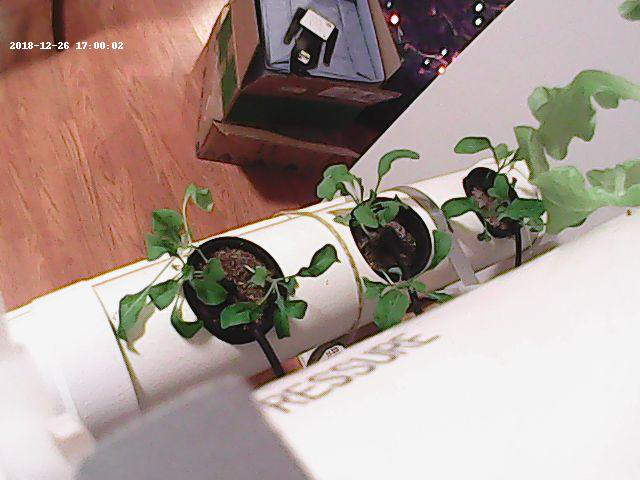

In [87]:
first = Image.open(open('%s%s'%(path, quad_recent[2][0]), 'rb'))
first

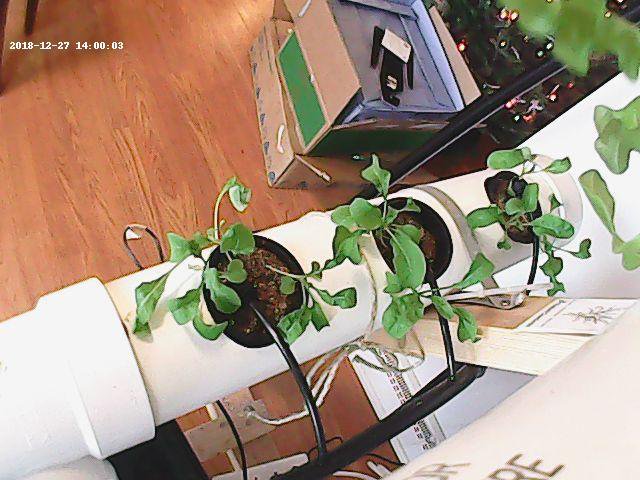

In [209]:
last = Image.open(open('%s%s'%(path, quad_recent[2][-1]), 'rb'))
last

In [130]:
count_green = lambda pic: len([pixel for pixel in list(pic.getdata()) if pixel[0]<175 and pixel[1]>200 and pixel[2]<175])
count_green(first)
             

13

In [131]:
count_green(last)

1890

In [210]:
# calculate the percent difference for each quadrant
data = pd.DataFrame()
for q in range(4):
    col = []
    for i in range(1, len(quad_recent[q])):
        file = quad_recent[q][i]
        date = ' '.join(file.split('_')[1:])[:-7]
        pic0 = Image.open(open('%s%s'%(path, quad_recent[q][i-1]), 'rb'))
        pic1 = Image.open(open('%s%s'%(path, quad_recent[q][i]), 'rb'))
    
        green0 = count_green(pic0)+1
        green1 = count_green(pic1)+1
        col.append((green1-green0)/green1)
    data['quad%s'%(q+1)] = col
data

,quad1,quad2,quad3,quad4
0,0.851852,0.975945,0.966981,0.600000
1,0.035714,-0.359813,-0.258160,-0.666667
2,-0.217391,-1.367257,-0.316406,0.500000
3,0.676056,-1.366492,-1.694737,-2.000000
4,-0.203390,-0.690265,0.274809,0.428571
5,0.421569,-112.000000,-130.000000,-6.000000
6,-101.000000,0.000000,0.000000,0.000000
7,0.000000,0.500000,0.000000,0.000000
8,0.000000,-1.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000


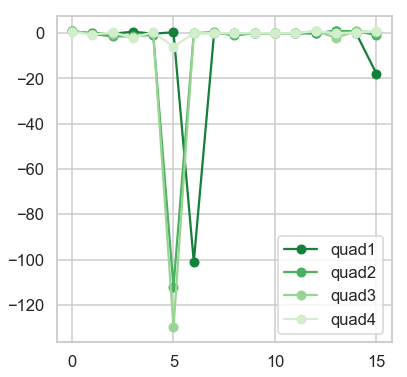

In [195]:
colors = sns.color_palette('Greens', 4)
plt.figure(figsize=(6,6))
for quad in data:
    plt.plot(data[quad], 'o-', color=colors.pop(), label=quad)
plt.legend()

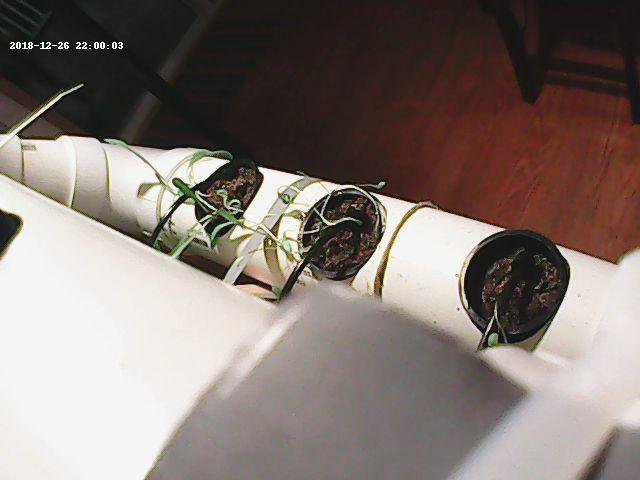

In [200]:
Image.open(open('%s%s'%(path, quad_recent[3][5]), 'rb'))

Quad4 has very little green to begin with so it doesn't register quite as large a drop.

Text(0,0.5,'percent growth in green pixels')

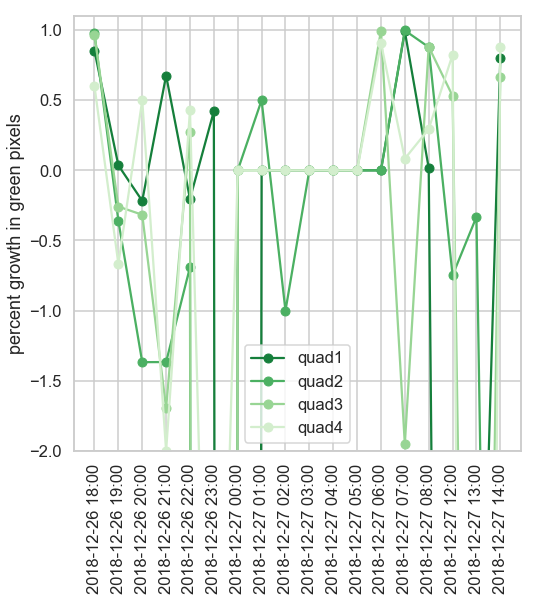

In [217]:
colors = sns.color_palette('Greens', 4)
sns.set_style('whitegrid')
plt.figure(figsize=(8,8))
for quad in data:
    #plt.plot(data[quad].rolling(3).mean(), 'o-', color=colors.pop(), label=quad)
    plt.plot(data[quad], 'o-', color=colors.pop(), label=quad)
plt.ylim(-2,1.1)
ticks = [' '.join(file.split('_')[1:])[:-7] for file in quad_recent[0]]
plt.xticks(range(len(data)), ticks[1::], rotation=90)
plt.legend()
plt.ylabel('percent growth in green pixels')

perhaps hourly is too short of a window to adquetly calculate growth. Maybe compare daily averages instead

In [187]:
ticks = [' '.join(file.split('_'))[:-4] for file in quad_recent[0]]
ticks

['q1 2018-12-26 17:00:02',
 'q1 2018-12-26 18:00:03',
 'q1 2018-12-26 19:00:03',
 'q1 2018-12-26 20:00:03',
 'q1 2018-12-26 21:00:03',
 'q1 2018-12-26 22:00:03',
 'q1 2018-12-26 23:00:03',
 'q1 2018-12-27 00:00:03',
 'q1 2018-12-27 01:00:03',
 'q1 2018-12-27 02:00:02',
 'q1 2018-12-27 03:00:03',
 'q1 2018-12-27 04:00:03',
 'q1 2018-12-27 05:00:03',
 'q1 2018-12-27 06:00:03',
 'q1 2018-12-27 07:00:02',
 'q1 2018-12-27 08:00:03',
 'q1 2018-12-27 12:00:03']